## Формирование структуры набора данных

Импортируем библиотеки необходимые для работы с набором данных и очистки данных (стоп слова), стемминга и лемматизации

In [24]:
import numpy as np
import pandas as pd

import nltk
import pymorphy3
import seaborn as sns
import matplotlib.pyplot as plt

# регулярные выражения
import re

# для пунктуационного списка
import string

import warnings
warnings.filterwarnings("ignore")

In [2]:
nltk.download("stopwords", quiet=True);

In [3]:
df = pd.read_csv("data/habr.csv", index_col="Unnamed: 0")
df.head()

,title,namecompany,description,rating,field,date,textpub
0,Geniatech XPI-3566-Zero: что это за одноплатни...,МТС,Экосистема цифровых сервисов,964.59,"Связь и телекоммуникации, Мобильные технологии...",2024-01-22,С момента выпуска первого Raspberry Pi популяр...
1,Как я за один заход хакнул половину американск...,Wunder Fund,Мы занимаемся высокочастотной торговлей на бирже,76.84,Программное обеспечение,2024-01-22,Консоль бодро оповестила меня о завершении раб...
2,Золотая эпоха в микроэлектронике,RUVDS.com,VDS/VPS-хостинг. Скидка 15% по коду HABR15,2904.69,"Связь и телекоммуникации, Домены и хостинг, Ве...",2024-01-22,"Минувший год окончательно доказал, что микр..."
3,CodeLLM теперь в Поиске Brave,Brave,Browse privately. Search privately. Ditch Big ...,37.27,"Программное обеспечение, Поисковые технологии,...",2024-01-22,Поиск Brave теперь включает в себя CodeLLM на ...
4,Личный опыт: переход с Redux на Effector. И пр...,SimbirSoft,Лидер в разработке современных ИТ-решений на з...,66.97,"Веб-разработка, Программное обеспечение, Мобил...",2024-01-22,Frontend-разработка очень богата различными ин...


In [4]:
df.shape

(88, 7)

## Анализ основных свойств данных

In [5]:
df.describe(include="object")

,title,namecompany,description,field,date,textpub
count,88,88,88,88,88,88
unique,88,52,46,40,5,88
top,Geniatech XPI-3566-Zero: что это за одноплатни...,МТС,Компания,"Связь и телекоммуникации, Мобильные технологии...",2024-01-19,С момента выпуска первого Raspberry Pi популяр...
freq,1,8,11,9,31,1


* namecompany: 52 уникальных значения, самое популярное "MTC", встречается 8 раз
* decription: 40 уникальных значения, самое популярное "Компания", встречается 11 раз

## Предварительная обработка данных

Для очистки текстовых данных выполним следующие действия:
* Очистка от латинских символов
* Очистка от пунктуационных и спец символов
* Очистка от цифр
* Очистка от лишних пробелов и пробельных символов
* Перевод в нижний регистр
* Удаление стоп слов
* Лемматизация

Подготовим функции для удобной обработки текстовых данных

In [6]:
def remove_latinic_and_numbers(text: str) -> str:
    return re.sub("[a-z0-9]", "", text)

def remove_punctuation(text: str) -> str:
    return "".join([char for char in text if char not in string.punctuation])

def tokenize(text: str) -> list:
    return re.split("\W+", text)

def lemmatizing(tokenized_text: list) -> list:
    morph = pymorphy3.MorphAnalyzer()
    return [morph.parse(word)[0].normal_form for word in tokenized_text]

def remove_stop_words(tokenized_text: list) -> list:
    return [word for word in tokenized_text if word not in nltk.corpus.stopwords.words("russian") and word not in ["это", "который"]]

def remove_space_sybmols(text: str) -> str:
    return re.sub("\s+", " ", text).strip()

def process_text(text: str) -> str:
    text = remove_punctuation(text.lower())
    text = remove_latinic_and_numbers(text)
    
    tokens = tokenize(text)
    tokens = lemmatizing(tokens)
    tokens = remove_stop_words(tokens)
    
    return remove_space_sybmols(" ".join(tokens))

Обработаем следующие признаки: title, description, field и textpub

In [7]:
%%time

processed_df = pd.DataFrame()

for i in ["title", "description", "field", "textpub"]:
    # Выведем исходный текст для сравнения
    print("-------------------------------------------------------")
    print(f"Name: {i}")
    print(df[i].head())
    
    # Обрабатываем текстовые данные
    processed_df[i] = df[i].apply(lambda x: process_text(x))
    
    # Выведем полученный результат
    print(processed_df[i].head())
    print("-------------------------------------------------------")

-------------------------------------------------------
Name: title
0    Geniatech XPI-3566-Zero: что это за одноплатни...
1    Как я за один заход хакнул половину американск...
2                     Золотая эпоха в микроэлектронике
3                        CodeLLM теперь в Поиске Brave
4    Личный опыт: переход с Redux на Effector. И пр...
Name: title, dtype: object
0                               одноплатник способный
1    заход хакнуть половина американский сеть фастфуд
2                      золотой эпоха микроэлектроника
3                                               поиск
4                                 личный опыт переход
Name: title, dtype: object
-------------------------------------------------------
-------------------------------------------------------
Name: description
0                         Экосистема цифровых сервисов
1     Мы занимаемся высокочастотной торговлей на бирже
2           VDS/VPS-хостинг. Скидка 15% по коду HABR15
3    Browse privately. Search privatel

In [8]:
from wordcloud import WordCloud

def show_word_cloud(values: list) -> None:
    # Соеденим все слова из признака в одну строку и отобразим их с помощью облока слов
    words = " ".join(values)
    plt.imshow(WordCloud(background_color="white", height=4000, width=4000).generate(words))
    plt.show()

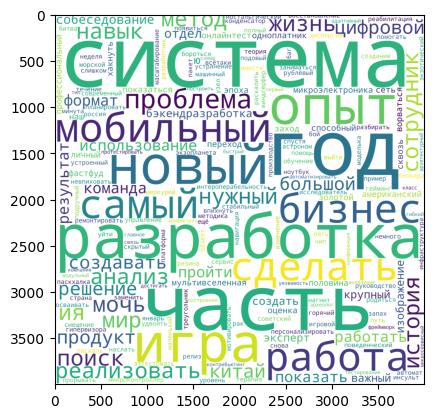

CPU times: total: 27 s
Wall time: 27.3 s


In [9]:
%%time
show_word_cloud(processed_df["title"].values)

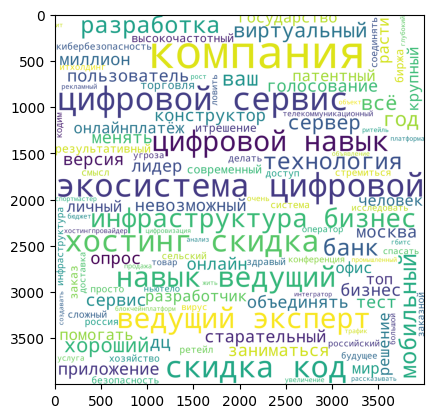

CPU times: total: 15.1 s
Wall time: 15.2 s


In [10]:
%%time
show_word_cloud(processed_df["description"].values)

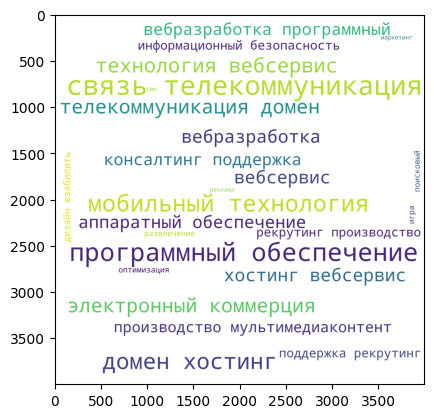

CPU times: total: 4.95 s
Wall time: 4.95 s


In [11]:
%%time
show_word_cloud(processed_df["field"].values)

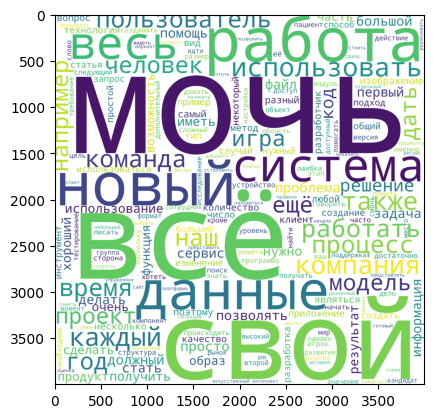

CPU times: total: 27.5 s
Wall time: 27.6 s


In [12]:
%%time
show_word_cloud(processed_df["textpub"].values)

## Векторизация

Так как модели кластеризации умеют работать только с числами, необходимо преобразовать текст в числовое представление. Этот процесс называется векторизацией.

TF-IDF - ститистическая мера, оценивающая важность слова в контексте конкретного документа. Это очень полечно, так как в большом тексте часто могут встречаться слова, не несущие смысловой нагрузки.


В имеющемся наборе данных, текст давольно длинный, так же нам не важен порядок слов. Будем использовать TF-IDF, так как он подходит под требования, а так же оценивает, насколько часто встречаются слове во всём тексте. Данная модель позволит преобразовать текстовые данные и использовать их в последствии для кластеризации.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(processed_df["textpub"])

In [14]:
tfidf_matrix.shape

(88, 12547)

В итоге получили матрицу TF-IDF, посмотрим на значисые слова.

In [15]:
tfidf_vectorizer.get_feature_names_out()[:100]

array(['φφ', 'абака', 'аббревиатура', 'абзац', 'абляциитаблица',
       'абонент', 'абразив', 'абразивный', 'абсолютно', 'абсолютный',
       'абстиненция', 'абстрагироваться', 'абстрактно', 'абстрактный',
       'абстракция', 'абьюзить', 'авангард', 'аварийный', 'аватар',
       'авгиев', 'август', 'авдеев', 'авиация', 'авитодорожка', 'авить',
       'аврал', 'аврор', 'аврора', 'австралия', 'австрия', 'автобус',
       'автобусный', 'автокодировщик', 'автомасштабирование', 'автомат',
       'автоматапройти', 'автоматизация', 'автоматизированный',
       'автоматизировать', 'автоматика', 'автоматикивозможный',
       'автоматически', 'автоматический', 'автоматичный', 'автомобиль',
       'автономия', 'автономно', 'автоответ', 'автор', 'авторизатор',
       'авторизациичерез', 'авторизационный', 'авторизация',
       'авторизоваться', 'авторизоватьсяпо', 'авторитарный', 'авторитет',
       'авторитетный', 'авторский', 'авторство', 'автостартегия',
       'автостратегийсначать', 'автостр

## Кластеризация

Определим оптимальное количество кластеров методом локтя

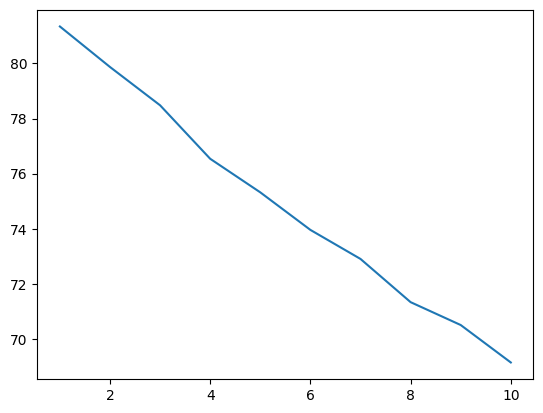

In [16]:
from sklearn.cluster import KMeans
wgss = []

for i in range(1, 11):
    kmean = KMeans(n_clusters=i, init="k-means++", random_state=0, n_init=10)
    kmean.fit(tfidf_matrix)
    wgss.append(kmean.inertia_)

plt.plot(range(1, 11), wgss);
plt.show()

Резкого перелома на графике нет, возьмём значение в 5 кластеров.

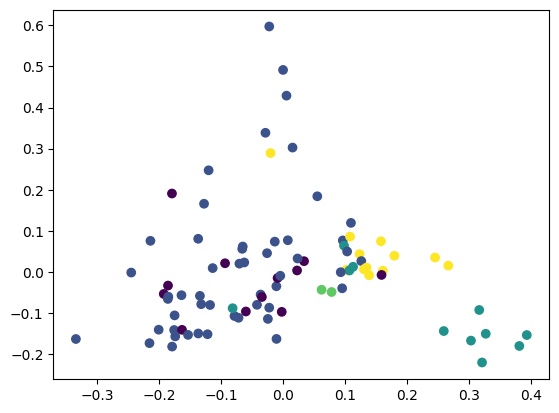

In [17]:
from sklearn.decomposition import PCA

x_pca = PCA().fit_transform(tfidf_matrix.toarray())

kmean = KMeans(n_clusters=5, init="k-means++", random_state=42, n_init=10)
kmean.fit(x_pca)
kmean_clusters = kmean.labels_.tolist()

plt.scatter(x_pca[:, 0], x_pca[:, 1], c=kmean_clusters);

In [18]:
kmean = KMeans(n_clusters=5, init="k-means++", random_state=42, n_init=10)
kmean.fit(tfidf_matrix)
kmean_clusters = kmean.labels_.tolist()

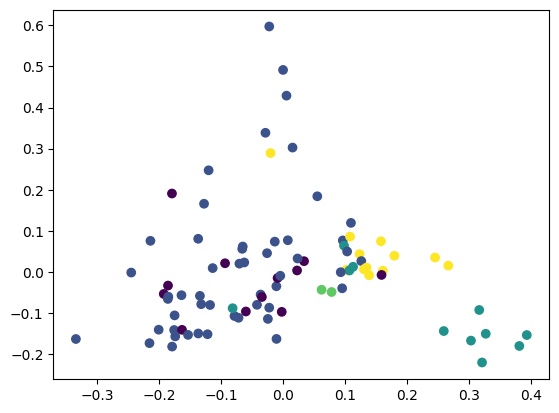

In [19]:
from sklearn.decomposition import PCA

x_pca = PCA().fit_transform(tfidf_matrix.toarray())
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=kmean_clusters);

In [20]:
out = {"textpub" : processed_df["textpub"], "kmean cluster" : kmean_clusters, "rating" : df["rating"]}
out_df = pd.DataFrame(out, columns=["textpub", "kmean cluster", "rating"])

In [21]:
out_df.head()

,textpub,kmean cluster,rating
0,момент выпуск первый популярность одноплатный ...,4,964.59
1,консоль бодро оповестить завершение работа скр...,1,76.84
2,минувший год окончательно доказать микроэлектр...,4,2904.69
3,поиск включать основа ия запрос связанный прог...,1,37.27
4,разработка очень богатый различный инструмент ...,1,66.97


Как видно, теперь строки относятся к одному из кластеров

In [22]:
out_df["kmean cluster"].value_counts()

kmean cluster
1    51
4    12
0    12
2    11
3     2
Name: count, dtype: int64

In [23]:
for i in range(0, 5):
    print(f"\nkmean cluster: {i}")
    print(out_df[out_df["kmean cluster"] == i])


kmean cluster: 0
                                              textpub  kmean cluster   rating
8   привет хабра звать алексей колесников работать...              0   131.93
9   привет хабра звать юрий петров автор ютубканал...              0    57.55
31  ежегодно российский компания создавать десятка...              0  1528.63
40  источник далеко всё специалист говорить обычны...              0   510.49
45  писать декабрь прошлое год роскомнадзор разреш...              0   301.45
46  ход расследование инцидент обнаружить целый кл...              0   194.75
48  мессенджер средство авторизация подоплёка проб...              0    48.29
52  весь привет недавно переработать интерфейс наш...              0   136.42
70  весь год рассказывать новый фича акция план бу...              0  1528.63
71  инженерный дать векепривет друг понять заголов...              0    89.87
81  рассказывать проблема связанный доступность ши...              0    95.33
85  привет хабра компания запустить подкаст го